In [14]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [15]:
dataset_path = 'sentiment_analysis.csv'
dataset = pd.read_csv(dataset_path, index_col='id')
dataset.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [16]:
def text_normalize(text):
    text = re.sub(r'^RT[\s]+', '', text)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    text = re.sub(r'#', '', text)

    text = re.sub(r'[^\w\s]', '', text)

    tokenize = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenize.tokenize(text)

    return text_tokens

In [17]:
def get_freq(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
         tweet = row['tweet']
         label = row['label']

         tokens = text_normalize(tweet)
         for token in tokens:
              pair = (token, label)
              freqs[pair] += 1
    return freqs

In [18]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 1)]
        X[2] += freqs[(token, 0)]

    return X

In [19]:
X = []
Y = []

freqs = get_freq(dataset)
for idx, row in dataset.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    Y.append(label)

X = np.array(X)
Y = np.array(Y)

In [20]:
print(X.shape)

(7920, 3)


In [27]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=random_state, shuffle=is_shuffle
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_size, random_state=random_state, shuffle=is_shuffle
)

In [28]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [29]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1-1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, learning_rate):
    return theta - learning_rate * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    return acc

In [30]:
learning_rate = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [31]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i+batch_size]
        y_i = y_train[i:i+batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, learning_rate)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_batch_losses.append(val_loss)

        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    val_losses.append(val_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)

    print(f'\nEpoch {epoch+1}: \tTraining loss : {train_batch_loss:.3f} \tValidation loss : {val_batch_loss:.3f}')


Epoch 1: 	Training loss : 0.774 	Validation loss : 0.757

Epoch 2: 	Training loss : 0.724 	Validation loss : 0.710

Epoch 3: 	Training loss : 0.684 	Validation loss : 0.671

Epoch 4: 	Training loss : 0.650 	Validation loss : 0.639

Epoch 5: 	Training loss : 0.622 	Validation loss : 0.612

Epoch 6: 	Training loss : 0.598 	Validation loss : 0.590

Epoch 7: 	Training loss : 0.578 	Validation loss : 0.571

Epoch 8: 	Training loss : 0.561 	Validation loss : 0.556

Epoch 9: 	Training loss : 0.547 	Validation loss : 0.542

Epoch 10: 	Training loss : 0.535 	Validation loss : 0.531

Epoch 11: 	Training loss : 0.524 	Validation loss : 0.521

Epoch 12: 	Training loss : 0.514 	Validation loss : 0.512

Epoch 13: 	Training loss : 0.506 	Validation loss : 0.504

Epoch 14: 	Training loss : 0.499 	Validation loss : 0.498

Epoch 15: 	Training loss : 0.492 	Validation loss : 0.492

Epoch 16: 	Training loss : 0.486 	Validation loss : 0.486

Epoch 17: 	Training loss : 0.481 	Validation loss : 0.481

Epoch

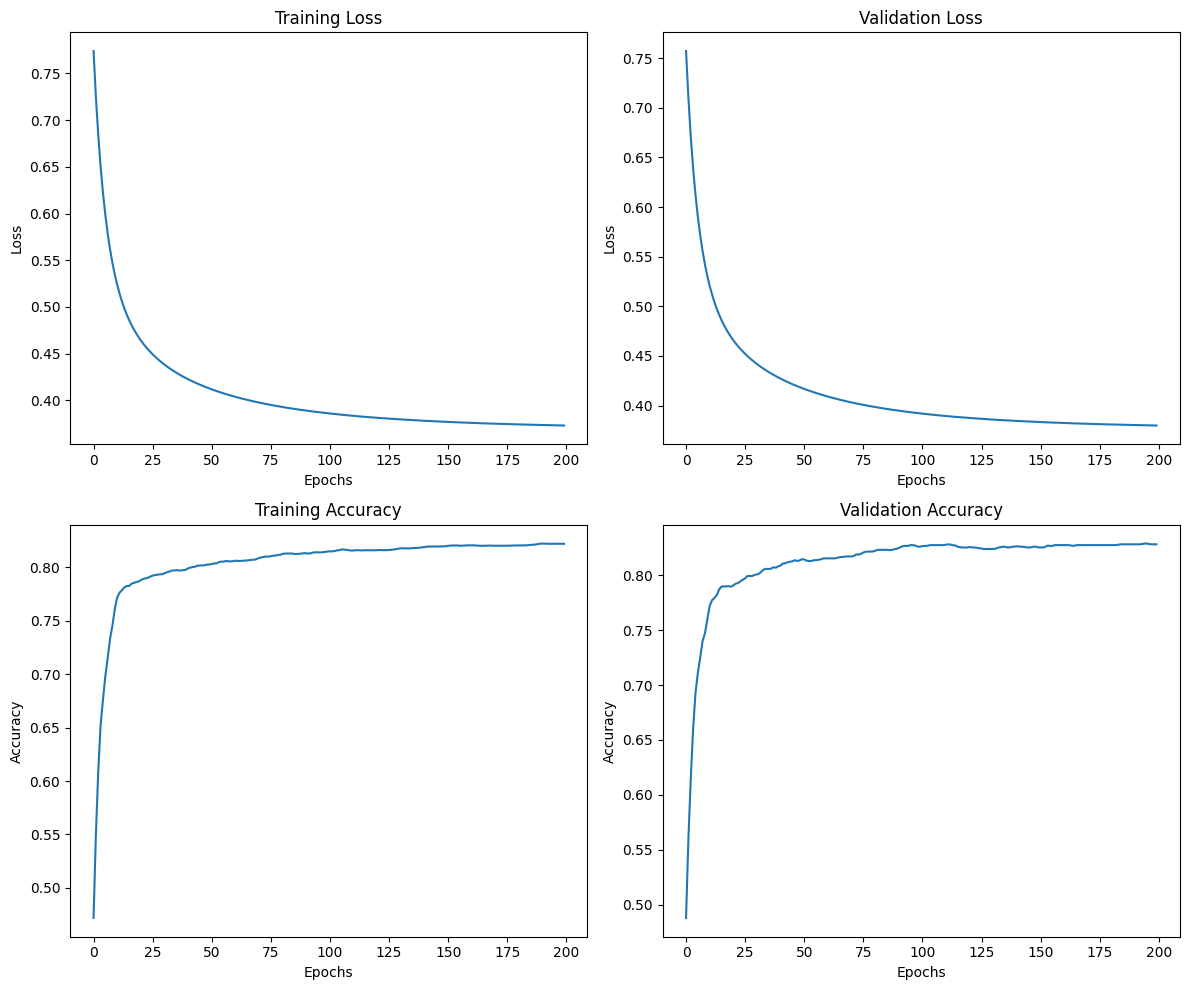

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epochs', ylabel='Loss', title='Training Loss')

ax[0, 1].plot(val_losses)
ax[0, 1].set(xlabel='Epochs', ylabel='Loss', title='Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epochs', ylabel='Accuracy', title='Training Accuracy')

ax[1, 1].plot(val_accs)
ax[1, 1].set(xlabel='Epochs', ylabel='Accuracy', title='Validation Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print(f'Accuracy :{val_set_acc}')
print(f'Accuracy :{test_set_acc}')